# Info
Purpose:

    Investigate the Oxygen-A changes when the Aerosol layer varies
    Based on gap analysis from ORACLES

Input:

    None

Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - Sp_parameters
    - write_utils
    - path_utils
    - hdf5storage
    - scipy

Needed Files:
  - starsun.mat files from ORACLES 2016
  - ORACLES2016_gap_v1.npy:  gap analysis from ORACLES 2016, from ORACLES_AOD_summary_allyears.ipynb

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2022-02-11
    Modified:


# Prepare python environment

In [41]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
import write_utils as wu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from scipy import interpolate

In [4]:
name = 'ORACLES'
vv = 'v1'
fp = getpath(name)


Return path named:  ORACLES /data/sam/ORACLES/


In [8]:
fpo = '/data/sunsat/ORACLES_2016/data_processed/starsuns/R3/'

# Load files

## Load gap files

In [112]:
gap6 = np.load(fp+'ORACLES2016_gap_{}.npy'.format(vv),allow_pickle=True,fix_imports=True,encoding='latin1')
gap6 = gap6.item()

In [6]:
gap7 = np.load(fp+'ORACLES2017_gap_{}.npy'.format(vv),allow_pickle=True,fix_imports=True,encoding='latin1')
gap7 = gap7.item()

In [7]:
gap8 = np.load(fp+'ORACLES2018_gap_{}.npy'.format(vv),allow_pickle=True,fix_imports=True,encoding='latin1')
gap8 = gap8.item()

In [9]:
gap6.keys()

dict_keys(['meas_low_index', 'dlat_ndays', 'dalt', 'dlat', 'aero_base_alt', 'daod', 'aero_base_day', 'dlon', 'meas_low_day', 'aero_base_index', 'aero_base_UTC', 'meas_low_UTC', 'dlon_ndays', 'dang'])

In [24]:
days6 = [d.strftime('%Y%m%d') for d in gap6['aero_base_day']]
day6 = np.unique(days6)

In [25]:
day6

array(['20160827', '20160831', '20160902', '20160904', '20160906',
       '20160908', '20160910', '20160912', '20160914', '20160918',
       '20160920', '20160924', '20160925', '20160927'], dtype='<U8')

## Load starsun files

### Load 2016

In [27]:
s6 = []
for d in day6:
    ss = hs.loadmat(fpo+'4STAR_{}starsun.mat'.format(d),variable_names=['tau_aero','w','t','Pst'])
    ss['filename'] = fpo+'4STAR_{}starsun.mat'.format(d)
    s6.append(ss)

In [28]:
len(s6)

14

In [30]:
s6[0].keys()

dict_keys(['__header__', '__version__', '__globals__', 't', 'Pst', 'w', 'tau_aero'])

In [31]:
for ss in s6:
    ss['utc'] = lu.mat2py_time(ss['t'])

## Calculate the Ox-a depth

In [39]:
def oxa_depth(w,spec):
    'calculate the oxygen-a depth. w: wavelenght in microns, spec: spectra(tau_aero)'
    y0 = np.argmin(abs(w-0.756))
    y1 = np.argmin(abs(w-0.772))
    oxa_flat,oxa_delta = [],[]
    for i in range(len(spec)):
        fx = interpolate.interp1d(w[0,[y0,y1]],spec[i,[y0,y1]])
        oxa_flat.append(fx(w[0,y0:y1]))
        oxa_delta.append(np.nansum(spec[i,y0:y1]-oxa_flat))
    return np.array(oxa_delta)

In [53]:
for j,ss in enumerate(s6):
    print('Doing file {}, which is {}/{}'.format(day6[j],j,len(s6)))
    if 'oxa_delta' in ss.keys(): 
        print('Yas queen already in there')
        continue
    try:
        ss['oxa_delta'] = oxa_depth(ss['w'],ss['tau_aero'])
    except:
        pass

Doing file 20160827, which is 0/14
Yas queen already in there
Doing file 20160831, which is 1/14
Yas queen already in there
Doing file 20160902, which is 2/14
Yas queen already in there
Doing file 20160904, which is 3/14
Yas queen already in there
Doing file 20160906, which is 4/14
Yas queen already in there
Doing file 20160908, which is 5/14
Yas queen already in there
Doing file 20160910, which is 6/14
Yas queen already in there
Doing file 20160912, which is 7/14
Yas queen already in there
Doing file 20160914, which is 8/14
Doing file 20160918, which is 9/14
Doing file 20160920, which is 10/14
Doing file 20160924, which is 11/14
Doing file 20160925, which is 12/14
Doing file 20160927, which is 13/14


## Get the oxa depth for the gap times

In [75]:
dd = gap6['aero_base_day'][1]

In [80]:
utc_fx = lambda x: x.hour+(x.minute+(x.second/60.0))/60.0

In [95]:
s6[iu].keys()

dict_keys(['__header__', '__version__', '__globals__', 't', 'Pst', 'w', 'utc'])

In [111]:
len(gap6['aero_base_alt'])

138

In [124]:
n = len(gap6['aero_base_day'])
oxa_aero_base,oxa_meas,press_meas,aod = np.zeros((n))+np.nan,np.zeros((n))+np.nan,np.zeros((n))+np.nan,np.zeros((n))+np.nan 
for i,dd in enumerate(gap6['aero_base_day']):
    iu = np.where(day6==days6[i])[0][0]
    it = np.argmin(abs(dd-s6[iu]['utc']))
    try:
        oxa_aero_base[i] = s6[iu]['oxa_delta'][it]
    except KeyError:
        continue
    it2 = np.argmin(abs(gap6['meas_low_day'][i]-s6[iu]['utc']))
    oxa_meas[i] = s6[iu]['oxa_delta'][it2]
    press_meas[i] = s6[iu]['Pst'][it2]
    aod[i] = s6[iu]['tau_aero'][it2,407]

In [123]:
s6[iu]['w'][0,407]

0.500682

# Plot out data

<IPython.core.display.Javascript object>


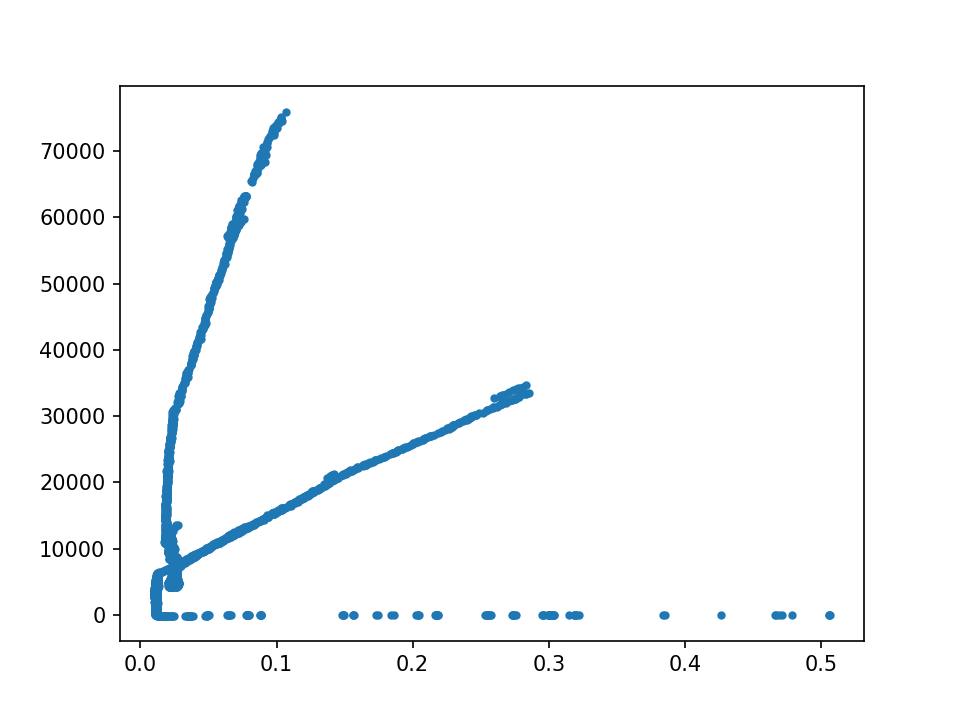

In [56]:
plt.figure()
plt.plot(s6[0]['tau_aero'][:,500],s6[0]['oxa_delta'],'.')

In [117]:
oxa_meas[oxa_meas==0.0] = np.nan

In [137]:
import plotting_utils as pu

<IPython.core.display.Javascript object>


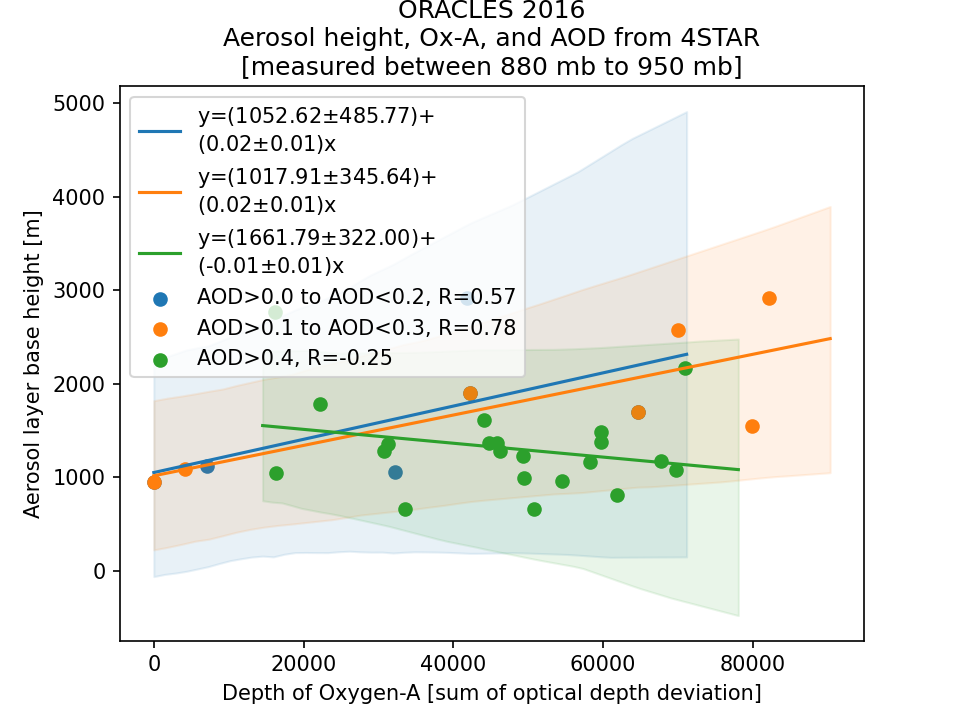

In [174]:
plt.figure()
i_low = (press_meas>880.0) & (press_meas<950.0) & (aod>0.0) & (aod<0.2)
plt.scatter(oxa_meas[i_low],gap6['aero_base_alt'][i_low],
            label='AOD>0.0 to AOD<0.2, R={:1.2f}'.format(np.corrcoef(gap6['aero_base_alt'][i_low],oxa_meas[i_low])[1,0]))
pu.plot_lin(oxa_meas[i_low],gap6['aero_base_alt'][i_low],color='tab:blue')

i_low = (press_meas>880.0) & (press_meas<950.0)& (aod>0.1) & (aod<0.3)
plt.scatter(oxa_meas[i_low],gap6['aero_base_alt'][i_low],
            label='AOD>0.1 to AOD<0.3, R={:1.2f}'.format(np.corrcoef(gap6['aero_base_alt'][i_low],oxa_meas[i_low])[1,0]))
pu.plot_lin(oxa_meas[i_low],gap6['aero_base_alt'][i_low],color='tab:orange')

i_low = (press_meas>880.0) & (press_meas<950.0) & (aod>0.4)
plt.scatter(oxa_meas[i_low],gap6['aero_base_alt'][i_low],
            label='AOD>0.4, R={:1.2f}'.format(np.corrcoef(gap6['aero_base_alt'][i_low],oxa_meas[i_low])[1,0]))
pu.plot_lin(oxa_meas[i_low],gap6['aero_base_alt'][i_low],color='tab:green')

#i_low = (press_meas>880.0) & (press_meas<950.0) & (aod>0.6)
#plt.scatter(oxa_meas[i_low],gap6['aero_base_alt'][i_low],label='AOD>0.6')
#pu.plot_lin(oxa_meas[i_low],gap6['aero_base_alt'][i_low],color='tab:red')
#plt.colorbar(label='Pressure [mb]')
plt.legend()
plt.xlabel('Depth of Oxygen-A [sum of optical depth deviation]')
plt.ylabel('Aerosol layer base height [m]')
plt.title('ORACLES 2016\nAerosol height, Ox-A, and AOD from 4STAR\n[measured between 880 mb to 950 mb]')
plt.savefig(fp+'ORACLES2016_OXa_vs_aero_alt_{}.png'.format(vv),dpi=600,transparent=True)